<a href="https://colab.research.google.com/github/Adityaaaaaaaaaaaaaaa/python_ml_training_hpc/blob/main/HPC_sem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset link:** < [Taxi](https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data/data) >




# Slave Check

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Lazy mode

Uplaoding dataset via kaggle API

Step 1 - Our Slave

In [ ]:
!nvidia-smi

Thu Sep 11 17:05:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Step 2 - Upload Kaggle API Key

Use the kaggle.json from Kaggle account, upload it here:

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"user2025hpc","key":"33bc216d7c30ca7f79f2b9bd3c6269f6"}'}

Step 3: Configure Kaggle API

Move uploaded API key into the correct folder:

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Step 4: Download the NYC Yellow Taxi Dataset

Use the Kaggle API to download the dataset zip:

In [ ]:
!kaggle datasets download -d elemento/nyc-yellow-taxi-trip-data

Dataset URL: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data
License(s): U.S. Government Works
 98% 1.75G/1.78G [00:16<00:00, 90.7MB/s]
100% 1.78G/1.78G [00:16<00:00, 117MB/s] 


Step 5: Extract the Dataset

Unzip downloaded file into a folder called taxi_data:

In [ ]:
!unzip nyc-yellow-taxi-trip-data.zip -d taxi_data

Archive:  nyc-yellow-taxi-trip-data.zip
  inflating: taxi_data/yellow_tripdata_2015-01.csv  
  inflating: taxi_data/yellow_tripdata_2016-01.csv  
  inflating: taxi_data/yellow_tripdata_2016-02.csv  
  inflating: taxi_data/yellow_tripdata_2016-03.csv  


List the files:

In [ ]:
import os
os.listdir("taxi_data")[:10]   # show first 10 files

['yellow_tripdata_2016-01.csv',
 'yellow_tripdata_2015-01.csv',
 'yellow_tripdata_2016-03.csv',
 'yellow_tripdata_2016-02.csv']

# Google Drive mode

NYC Yellow Taxi Trip Data Analysis

Step 1: Mount Google Drive
We mount Google Drive so that we can directly access the taxi dataset stored in the `/MyDrive/taxi` folder.  
This way, the data is persisted and we do not need to re-upload every time we open Colab.

In [1]:
# =====================================
# BLOCK 1: MOUNT DRIVE & CHECK ORIGINAL FILES
# =====================================
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to taxi folder
data_folder = "/content/drive/MyDrive/taxi"

# Original 4 files
taxi_files = [
    os.path.join(data_folder, "yellow_tripdata_2015-01.csv"),
    os.path.join(data_folder, "yellow_tripdata_2016-01.csv"),
    os.path.join(data_folder, "yellow_tripdata_2016-02.csv"),
    os.path.join(data_folder, "yellow_tripdata_2016-03.csv"),
]

print("Original files:")
print("+--------------------------------------------------+")
for f in taxi_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / (1024**2)
        print(f"✔ {os.path.basename(f)} ({size:.2f} MB)")
    else:
        print(f"⚠ Missing: {f}")
print("+--------------------------------------------------+")

Mounted at /content/drive
Original files:
+--------------------------------------------------+
✔ yellow_tripdata_2015-01.csv (1893.96 MB)
✔ yellow_tripdata_2016-01.csv (1629.52 MB)
✔ yellow_tripdata_2016-02.csv (1700.93 MB)
✔ yellow_tripdata_2016-03.csv (1825.97 MB)
+--------------------------------------------------+


Merge into `taxi.csv`

In [2]:
# =====================================
# BLOCK 2: MERGE FILES INTO taxi.csv
# =====================================
combined_file = os.path.join(data_folder, "taxi.csv")

if not os.path.exists(combined_file):
    print("Merging 4 files into taxi.csv ... this took 18 mins to make.")

    header_written = False
    with open(combined_file, "w") as fout:
        for f in taxi_files:
            for chunk in pd.read_csv(f, chunksize=500000):
                chunk.to_csv(fout, index=False, header=not header_written, mode="a")
                header_written = True
    print("✔ taxi.csv created successfully.")
else:
    print("✔ taxi.csv already exists, skipping merge.")

Merging 4 files into taxi.csv ... this may take several minutes.
✔ taxi.csv created successfully.


# Always Run This Block **first** in Every Session

In [14]:
# =====================================
# BLOCK 3: LOAD taxi.csv (EVERY SESSION, RANDOM SAMPLE)
# =====================================
import pandas as pd
import os
import numpy as np
from google.colab import drive

# Mount Drive (safe every session)
drive.mount('/content/drive')

# Paths
data_folder = "/content/drive/MyDrive/taxi"
combined_file = os.path.join(data_folder, "taxi.csv")

# Count total rows in taxi.csv (excluding header)
with open(combined_file, "r") as f:
    total_rows = sum(1 for _ in f) - 1

print(f"✔ taxi.csv found with {total_rows:,} rows")

# Sample size
sample_size = 100_000   # Set to 10_000_000 or 15_000_000 if memory allows
# set 100k for ML Training

# Pick random rows to load
skip = sorted(
    np.random.choice(
        np.arange(1, total_rows + 1),  # skip these row indices
        size=(total_rows - sample_size),
        replace=False
    )
)

df_sample = pd.read_csv(combined_file, skiprows=skip, low_memory=False)

print(f"✔ Random sample loaded: {len(df_sample):,} rows")
print("Columns available:", df_sample.columns.tolist()) #47,248,845 rows total


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ taxi.csv found with 47,248,845 rows
✔ Random sample loaded: 100,000 rows
Columns available: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']


# Pandas

101 - Setup (Code)

In [2]:
# =====================================
# SETUP PANDAS FOLDER
# =====================================
pandas_folder = os.path.join(data_folder, "pandas")
os.makedirs(pandas_folder, exist_ok=True)

print("✔ Pandas folder ready at:", pandas_folder)

✔ Pandas folder ready at: /content/drive/MyDrive/taxi/pandas


In [3]:
# =====================================
# P1 – BASIC INSPECTION
# =====================================

print("\nFirst 5 rows:")
print(df_sample.head())

print("\nLast 5 rows:")
print(df_sample.tail())

print("\nDataset shape (rows, columns):", df_sample.shape)

print("\nAvailable columns:")
print(df_sample.columns.tolist())

print("\nData types:")
print(df_sample.dtypes)

print("\nGeneral info:")
print(df_sample.info())


First 5 rows:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:39   2015-01-10 21:11:35                3   
2         1  2015-01-10 20:33:41   2015-01-10 20:35:23                1   
3         1  2015-01-10 20:33:41   2015-01-10 21:03:04                1   
4         2  2015-01-15 19:05:41   2015-01-15 19:10:22                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1          18.20        -73.783043        40.644356           2   
2           0.30        -74.008362        40.704376           1   
3           3.10        -73.973946        40.760448           1   
4           0.89        -73.994957        40.745079           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.75061

In [4]:
# =====================================
# P2 – DESCRIPTIVE STATISTICS
# =====================================

# 1. Summary statistics
print("\nSummary Statistics:")
print(df_sample.describe(include="all").transpose())

# 2. Missing values
print("\nMissing values per column:")
print(df_sample.isnull().sum())

# 3. Value counts for categorical columns
print("\nVendorID distribution:")
print(df_sample["VendorID"].value_counts())

print("\nPayment type distribution:")
print(df_sample["payment_type"].value_counts())

# 4. Numerical aggregates
print("\nMean trip distance:", df_sample["trip_distance"].mean())
print("Median trip distance:", df_sample["trip_distance"].median())
print("Std dev of fare_amount:", df_sample["fare_amount"].std())

# 5. Example of safe aggregation on full file with chunksize
chunk_iter = pd.read_csv(combined_file, chunksize=500000, usecols=["trip_distance"])
total_sum = 0
total_count = 0
for chunk in chunk_iter:
    total_sum += chunk["trip_distance"].sum()
    total_count += chunk["trip_distance"].count()
mean_distance_full = total_sum / total_count
print("\n[Full taxi.csv computed with chunksize] Mean trip distance:", mean_distance_full)


Summary Statistics:
                           count   unique                  top     freq  \
VendorID               5000000.0      NaN                  NaN      NaN   
tpep_pickup_datetime     5000000  3799101  2015-01-05 09:39:49       10   
tpep_dropoff_datetime    5000000  3801112  2015-01-02 00:00:00       20   
passenger_count        5000000.0      NaN                  NaN      NaN   
trip_distance          5000000.0      NaN                  NaN      NaN   
pickup_longitude       5000000.0      NaN                  NaN      NaN   
pickup_latitude        5000000.0      NaN                  NaN      NaN   
RateCodeID             5000000.0      NaN                  NaN      NaN   
store_and_fwd_flag       5000000        2                    N  4967323   
dropoff_longitude      5000000.0      NaN                  NaN      NaN   
dropoff_latitude       5000000.0      NaN                  NaN      NaN   
payment_type           5000000.0      NaN                  NaN      NaN   
fare

In [5]:
# =====================================
# P3 – DATA CLEANING
# =====================================
p3_folder = os.path.join(pandas_folder, "p3")
os.makedirs(p3_folder, exist_ok=True)

# 1. Missing values
print("\nMissing values per column:")
print(df_sample.isnull().sum())

# Drop rows with missing values
df_dropna = df_sample.dropna()
print(f"\nRows after dropna: {len(df_dropna)} / {len(df_sample)}")

# Fill missing numeric values with 0
df_fillna = df_sample.fillna(0)

# 2. Remove duplicates
df_nodup = df_sample.drop_duplicates(subset=["passenger_count", "trip_distance"])
print(f"\nRows after dropping duplicates: {len(df_nodup)} / {len(df_sample)}")

# 3. Replace values for payment_type
df_replace = df_sample.copy()
df_replace["payment_type"] = df_replace["payment_type"].replace({
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
})
print("\nPayment type value counts after replace:")
print(df_replace["payment_type"].value_counts())

# 4. Save cleaned sample
output_file = os.path.join(p3_folder, "p3_cleaned_sample.csv")
df_replace.to_csv(output_file, index=False)
print(f"\n✔ Cleaned sample saved to: {output_file}")



Missing values per column:
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    1
total_amount             0
dtype: int64

Rows after dropna: 4999999 / 5000000

Rows after dropping duplicates: 15960 / 5000000

Payment type value counts after replace:
payment_type
Credit Card    3267272
Cash           1709533
No Charge        17356
Dispute           5839
Name: count, dtype: int64

✔ Cleaned sample saved to: /content/drive/MyDrive/taxi/pandas/p3/p3_cleaned_sample.csv


In [7]:
# =====================================
# P4 – SELECTION & FILTERING
# =====================================

# 1. Selecting columns
print("\nSingle column (trip_distance):")
print(df_sample["trip_distance"].head())

print("\nMultiple columns (passenger_count, fare_amount):")
print(df_sample[["passenger_count", "fare_amount"]].head())

# 2. Selecting rows
print("\nFirst row with iloc[0]:")
print(df_sample.iloc[0])

print("\nRow with index 100 using loc:")
print(df_sample.loc[100])

# 3. Boolean filtering
print("\nTrips with passenger_count > 2:")
print(df_sample[df_sample["passenger_count"] > 2].head())

print("\nTrips with fare_amount > 50:")
print(df_sample[df_sample["fare_amount"] > 50].head())

# 4. Multiple conditions
print("\n(passenger_count > 2) AND (fare_amount > 50):")
print(df_sample[(df_sample["passenger_count"] > 2) & (df_sample["fare_amount"] > 50)].head())

print("\n(fare_amount < 5) OR (fare_amount > 100):")
print(df_sample[(df_sample["fare_amount"] < 5) | (df_sample["fare_amount"] > 100)].head())

# 5. Using query()
print("\nUsing query() for passenger_count == 1 and trip_distance > 5:")
print(df_sample.query("passenger_count == 1 and trip_distance > 5").head())



Single column (trip_distance):
0     1.59
1    18.20
2     0.30
3     3.10
4     0.89
Name: trip_distance, dtype: float64

Multiple columns (passenger_count, fare_amount):
   passenger_count  fare_amount
0                1         12.0
1                3         52.0
2                1          3.0
3                1         19.0
4                1          5.5

First row with iloc[0]:
VendorID                                   2
tpep_pickup_datetime     2015-01-15 19:05:39
tpep_dropoff_datetime    2015-01-15 19:23:42
passenger_count                            1
trip_distance                           1.59
pickup_longitude                  -73.993896
pickup_latitude                    40.750111
RateCodeID                                 1
store_and_fwd_flag                         N
dropoff_longitude                 -73.974785
dropoff_latitude                   40.750618
payment_type                               1
fare_amount                             12.0
extra                    

In [8]:
# =====================================
# P5 – SORTING & INDEXING
# =====================================

# 1. Sorting by column values
print("\nSorting by fare_amount (ascending):")
print(df_sample.sort_values(by="fare_amount").head())

print("\nSorting by fare_amount (descending):")
print(df_sample.sort_values(by="fare_amount", ascending=False).head())

print("\nSorting by passenger_count then fare_amount:")
print(df_sample.sort_values(by=["passenger_count", "fare_amount"], ascending=[True, False]).head())

# 2. Sorting by row index
print("\nSorting by index (descending):")
print(df_sample.sort_index(ascending=False).head())

# 3. Changing the index
df_indexed = df_sample.set_index("tpep_pickup_datetime")
print("\nAfter setting pickup datetime as index:")
print(df_indexed.head())

# 4. Resetting the index
df_reset = df_indexed.reset_index()
print("\nAfter resetting the index:")
print(df_reset.head())


Sorting by fare_amount (ascending):
         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
109331          2  2015-01-11 03:56:15   2015-01-11 03:56:17                1   
2881053         2  2016-02-12 12:57:52   2016-02-12 13:00:29                3   
3991283         2  2016-03-11 03:48:06   2016-03-11 03:48:11                1   
1884080         2  2016-01-17 03:01:48   2016-01-17 03:05:25                2   
2766828         2  2016-02-07 01:53:43   2016-02-07 01:53:55                1   

         trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
109331            0.00          0.000000         0.000000           5   
2881053           0.00        -73.862381        40.768848           5   
3991283           0.10          0.000000         0.000000           5   
1884080           0.29        -74.002579        40.739750           5   
2766828           0.00        -73.993767        40.748341           5   

        store_and_fwd_flag  dropoff_l

In [9]:
# =====================================
# P6 – GROUPBY & AGGREGATIONS
# =====================================

# 1. GroupBy with single aggregation
print("\nAverage fare_amount per passenger_count:")
print(df_sample.groupby("passenger_count")["fare_amount"].mean())

print("\nNumber of trips per VendorID:")
print(df_sample.groupby("VendorID")["VendorID"].count())

# 2. GroupBy with multiple aggregations
print("\nAggregated statistics per payment_type:")
agg_stats = df_sample.groupby("payment_type").agg({
    "fare_amount": ["mean", "median", "max"],
    "trip_distance": ["mean", "max", "min"]
})
print(agg_stats)

# 3. Pivot table
print("\nPivot table: Average fare_amount by payment_type and passenger_count:")
pivot = pd.pivot_table(
    df_sample,
    values="fare_amount",
    index="payment_type",
    columns="passenger_count",
    aggfunc="mean"
)
print(pivot)


Average fare_amount per passenger_count:
passenger_count
0    14.002684
1    12.225174
2    12.916535
3    12.649777
4    12.868628
5    12.457253
6    12.201079
7    39.800000
8    61.300000
9    28.700000
Name: fare_amount, dtype: float64

Number of trips per VendorID:
VendorID
1    2352038
2    2647962
Name: VendorID, dtype: int64

Aggregated statistics per payment_type:
             fare_amount                 trip_distance                 
                    mean median      max          mean         max  min
payment_type                                                           
1              12.905222    9.5   999.98      4.145340   3180000.0  0.0
2              11.341586    8.5  8008.00     22.704935  19072628.8  0.0
3              11.994475    6.0  6400.00      2.868769       254.7  0.0
4              10.823513    7.0   220.00    282.835009   1633973.4  0.0

Pivot table: Average fare_amount by payment_type and passenger_count:
passenger_count          0          1          

In [10]:
# =====================================
# P7 – APPLY & CUSTOM FUNCTIONS
# =====================================

# 1. Using .apply() on a column
print("\nSquare root of trip_distance (first 5 values):")
print(df_sample["trip_distance"].apply(lambda x: x**0.5).head())

# 2. Using .map() on a column
print("\nPayment_type mapped to text labels (first 5 values):")
payment_map = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}
print(df_sample["payment_type"].map(payment_map).head())

# 3. Using .applymap() on a DataFrame
print("\nApplying rounding (applymap) on first 3 numeric columns:")
print(df_sample[["fare_amount", "tip_amount", "total_amount"]].applymap(lambda x: round(x, 1)).head())

# 4. Creating a custom column with apply
def tip_percentage(row):
    return (row["tip_amount"] / row["fare_amount"] * 100) if row["fare_amount"] > 0 else 0

df_sample["tip_percent"] = df_sample.apply(tip_percentage, axis=1)
print("\nNew column 'tip_percent' created (first 5 rows):")
print(df_sample[["fare_amount", "tip_amount", "tip_percent"]].head())


Square root of trip_distance (first 5 values):
0    1.260952
1    4.266146
2    0.547723
3    1.760682
4    0.943398
Name: trip_distance, dtype: float64

Payment_type mapped to text labels (first 5 values):
0    Credit Card
1           Cash
2           Cash
3    Credit Card
4    Credit Card
Name: payment_type, dtype: object

Applying rounding (applymap) on first 3 numeric columns:


/tmp/ipython-input-4016732105.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df_sample[["fare_amount", "tip_amount", "total_amount"]].applymap(lambda x: round(x, 1)).head())


   fare_amount  tip_amount  total_amount
0         12.0         3.2          17.1
1         52.0         0.0          58.1
2          3.0         0.0           4.3
3         19.0         3.0          23.3
4          5.5         1.6           8.9

New column 'tip_percent' created (first 5 rows):
   fare_amount  tip_amount  tip_percent
0         12.0        3.25    27.083333
1         52.0        0.00     0.000000
2          3.0        0.00     0.000000
3         19.0        3.00    15.789474
4          5.5        1.62    29.454545


In [11]:
# =====================================
# P8 – MERGING & CONCATENATING
# =====================================

# Create two small DataFrames for demonstration
df1 = df_sample[["VendorID", "fare_amount", "tip_amount"]].head(5)
df2 = df_sample[["VendorID", "trip_distance", "payment_type"]].head(5)

print("\nDF1:")
print(df1)

print("\nDF2:")
print(df2)

# 1. Concatenation (vertical)
df_concat_vertical = pd.concat([df1, df1], axis=0)
print("\nConcatenation (vertical stacking):")
print(df_concat_vertical)

# 2. Concatenation (horizontal)
df_concat_horizontal = pd.concat([df1, df2], axis=1)
print("\nConcatenation (horizontal side-by-side):")
print(df_concat_horizontal)

# 3. Merge on common column VendorID
df_merged = pd.merge(df1, df2, on="VendorID")
print("\nMerge on VendorID:")
print(df_merged)


DF1:
   VendorID  fare_amount  tip_amount
0         2         12.0        3.25
1         1         52.0        0.00
2         1          3.0        0.00
3         1         19.0        3.00
4         2          5.5        1.62

DF2:
   VendorID  trip_distance  payment_type
0         2           1.59             1
1         1          18.20             2
2         1           0.30             2
3         1           3.10             1
4         2           0.89             1

Concatenation (vertical stacking):
   VendorID  fare_amount  tip_amount
0         2         12.0        3.25
1         1         52.0        0.00
2         1          3.0        0.00
3         1         19.0        3.00
4         2          5.5        1.62
0         2         12.0        3.25
1         1         52.0        0.00
2         1          3.0        0.00
3         1         19.0        3.00
4         2          5.5        1.62

Concatenation (horizontal side-by-side):
   VendorID  fare_amount  tip_amoun

In [12]:
# =====================================
# P9 – EXPORTING DATA
# =====================================

p9_folder = os.path.join(pandas_folder, "p9")
os.makedirs(p9_folder, exist_ok=True)

# Use a small sample for export demo
export_sample = df_sample.head(1000)

# 1. Export to CSV
csv_path = os.path.join(p9_folder, "p9_export_sample.csv")
export_sample.to_csv(csv_path, index=False)
print(f"✔ Exported to CSV: {csv_path}")

# 2. Export to Excel
excel_path = os.path.join(p9_folder, "p9_export_sample.xlsx")
export_sample.to_excel(excel_path, index=False)
print(f"✔ Exported to Excel: {excel_path}")

# 3. Export to JSON
json_path = os.path.join(p9_folder, "p9_export_sample.json")
export_sample.to_json(json_path, orient="records", lines=True)
print(f"✔ Exported to JSON: {json_path}")

# 4. Export to Pickle
pickle_path = os.path.join(p9_folder, "p9_export_sample.pkl")
export_sample.to_pickle(pickle_path)
print(f"✔ Exported to Pickle: {pickle_path}")

✔ Exported to CSV: /content/drive/MyDrive/taxi/pandas/p9/p9_export_sample.csv
✔ Exported to Excel: /content/drive/MyDrive/taxi/pandas/p9/p9_export_sample.xlsx
✔ Exported to JSON: /content/drive/MyDrive/taxi/pandas/p9/p9_export_sample.json
✔ Exported to Pickle: /content/drive/MyDrive/taxi/pandas/p9/p9_export_sample.pkl


In [13]:
# =====================================
# P10 – ADVANCED QUERIES
# =====================================

# 1. Boolean masks (AND, OR, NOT)
print("\nTrips with fare_amount > 50 AND passenger_count > 2:")
print(df_sample[(df_sample["fare_amount"] > 50) & (df_sample["passenger_count"] > 2)].head())

print("\nTrips with fare_amount < 5 OR trip_distance > 20:")
print(df_sample[(df_sample["fare_amount"] < 5) | (df_sample["trip_distance"] > 20)].head())

print("\nTrips NOT paid by cash (payment_type != 2):")
print(df_sample[~(df_sample["payment_type"] == 2)].head())

# 2. Using query()
print("\nUsing query() for trips with passenger_count == 1 and fare_amount between 20 and 40:")
print(df_sample.query("passenger_count == 1 and 20 <= fare_amount <= 40").head())

# 3. Multiple conditions on different columns
print("\nTrips with tip_amount > 5 and total_amount > 50:")
print(df_sample.query("tip_amount > 5 and total_amount > 50").head())

# 4. String matching (check store_and_fwd_flag)
print("\nTrips where store_and_fwd_flag contains 'Y':")
print(df_sample[df_sample["store_and_fwd_flag"].astype(str).str.contains("Y")].head())


Trips with fare_amount > 50 AND passenger_count > 2:
     VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1           1  2015-01-10 20:33:39   2015-01-10 21:11:35                3   
144         1  2015-01-21 02:01:46   2015-01-21 02:32:14                3   
375         2  2015-01-24 18:38:59   2015-01-24 19:04:00                4   
684         2  2015-01-22 15:12:41   2015-01-22 16:02:28                6   
715         1  2015-01-01 07:02:13   2015-01-01 07:28:51                3   

     trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
1            18.20        -73.783043        40.644356           2   
144          20.00        -73.782219        40.644691           2   
375          16.88        -73.970787        40.754681           2   
684          16.13        -73.974266        40.760067           2   
715          18.10        -73.776894        40.645138           2   

    store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment

In [14]:
# =====================================
# P11 – HANDLING MISSING DATA
# =====================================

# 1. Count missing values per column
print("Missing values per column:")
print(df_sample.isnull().sum())

# 2. Drop rows with ANY missing values
df_no_na = df_sample.dropna()
print("\nAfter dropna -> Shape:", df_no_na.shape)

# 3. Fill missing values with constant (0 for numeric, 'Unknown' for text)
df_fill_const = df_sample.fillna({
    "passenger_count": 0,
    "fare_amount": 0,
    "tip_amount": 0,
    "total_amount": 0,
    "payment_type": "Unknown",
    "RatecodeID": "Unknown",
    "store_and_fwd_flag": "Unknown"
})
print("\nAfter fillna with constants (first 5 rows of payment_type, total_amount):")
print(df_fill_const[["payment_type", "total_amount"]].head())

# 4. Fill numeric columns with mean
df_fill_mean = df_sample.copy()
for col in ["trip_distance", "fare_amount", "tip_amount", "total_amount"]:
    df_fill_mean[col] = df_fill_mean[col].fillna(df_fill_mean[col].mean())
print("\nAfter fillna with column mean (trip_distance, fare_amount shown):")
print(df_fill_mean[["trip_distance", "fare_amount"]].head())

# 5. Forward fill
df_ffill = df_sample.fillna(method="ffill")
print("\nForward fill (first 5 rows of store_and_fwd_flag):")
print(df_ffill["store_and_fwd_flag"].head(10))

# 6. Backward fill
df_bfill = df_sample.fillna(method="bfill")
print("\nBackward fill (first 5 rows of store_and_fwd_flag):")
print(df_bfill["store_and_fwd_flag"].head(10))

Missing values per column:
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    1
total_amount             0
tip_percent              0
dtype: int64

After dropna -> Shape: (4999999, 20)

After fillna with constants (first 5 rows of payment_type, total_amount):
   payment_type  total_amount
0             1         17.05
1             2         58.13
2             2          4.30
3             1         23.30
4             1          8.92

After fillna with column mean (trip_distance, fare_amount shown):
   trip_distance  fare_amount
0           1.59         12.0


/tmp/ipython-input-1862447859.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df_sample.fillna(method="ffill")



Forward fill (first 5 rows of store_and_fwd_flag):
0    N
1    N
2    N
3    N
4    N
5    N
6    N
7    N
8    N
9    N
Name: store_and_fwd_flag, dtype: object


/tmp/ipython-input-1862447859.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bfill = df_sample.fillna(method="bfill")



Backward fill (first 5 rows of store_and_fwd_flag):
0    N
1    N
2    N
3    N
4    N
5    N
6    N
7    N
8    N
9    N
Name: store_and_fwd_flag, dtype: object


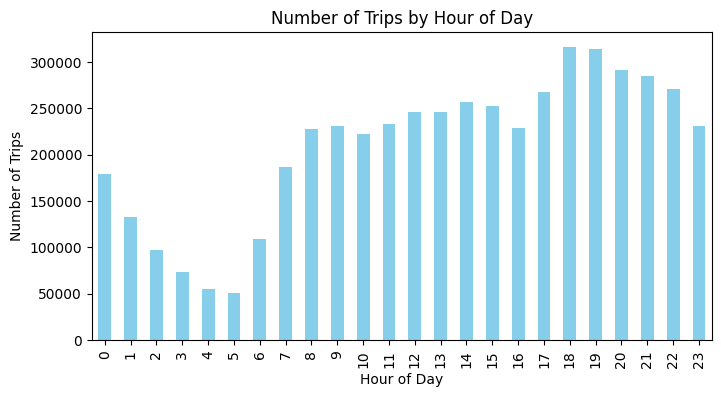

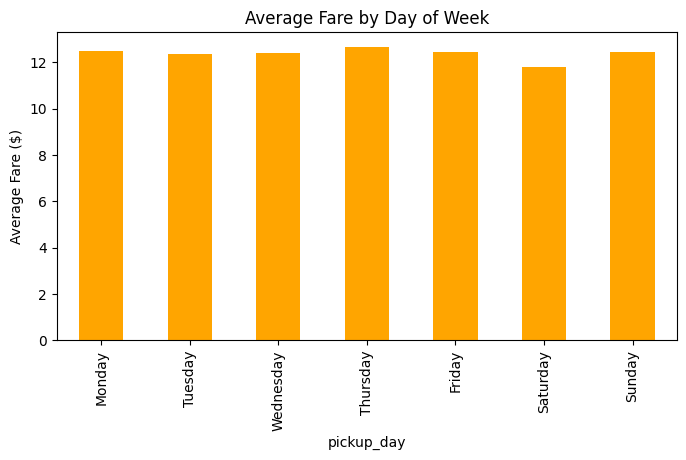

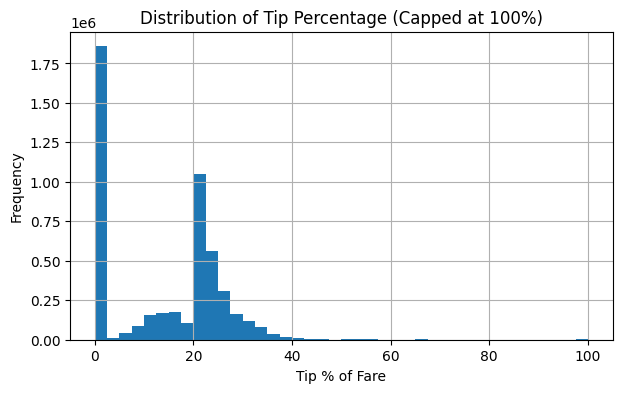

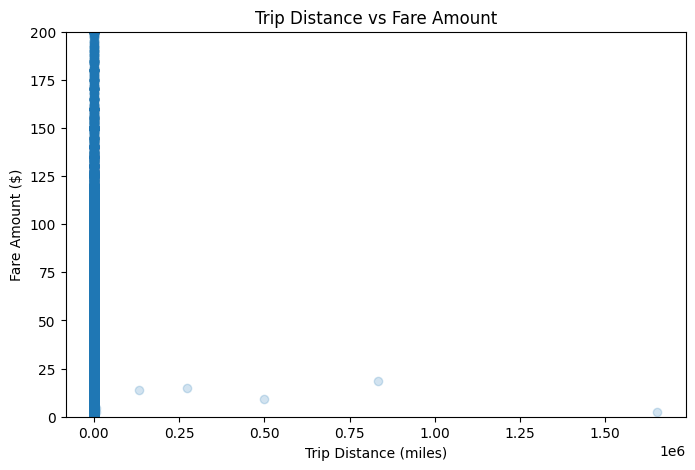

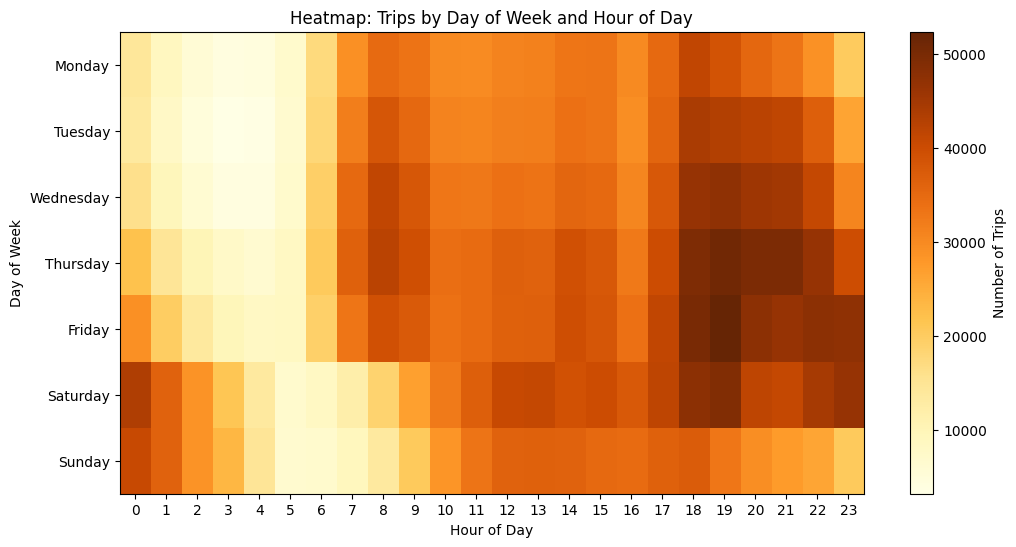

In [8]:
# =====================================
# P12 – DATA VISUALIZATION (Improved)
# =====================================
import matplotlib.pyplot as plt

# Ensure datetime conversion
df_sample["tpep_pickup_datetime"] = pd.to_datetime(df_sample["tpep_pickup_datetime"], errors="coerce")
df_sample["pickup_hour"] = df_sample["tpep_pickup_datetime"].dt.hour
df_sample["pickup_day"] = df_sample["tpep_pickup_datetime"].dt.day_name()

# 1. Trips per Hour of Day
trips_per_hour = df_sample.groupby("pickup_hour")["VendorID"].count()
plt.figure(figsize=(8,4))
trips_per_hour.plot(kind="bar", color="skyblue")
plt.title("Number of Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

# 2. Average Fare by Day of Week
avg_fare_day = df_sample.groupby("pickup_day")["fare_amount"].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
plt.figure(figsize=(8,4))
avg_fare_day.plot(kind="bar", color="orange")
plt.title("Average Fare by Day of Week")
plt.ylabel("Average Fare ($)")
plt.show()

# 3. Distribution of Tip % (tip_amount / fare_amount * 100)
df_sample["tip_percent"] = df_sample.apply(
    lambda row: (row["tip_amount"]/row["fare_amount"]*100) if row["fare_amount"]>0 else 0,
    axis=1
)
plt.figure(figsize=(7,4))
df_sample["tip_percent"].clip(0,100).hist(bins=40)
plt.title("Distribution of Tip Percentage (Capped at 100%)")
plt.xlabel("Tip % of Fare")
plt.ylabel("Frequency")
plt.show()

# 4. Scatter plot: Trip Distance vs Fare Amount
plt.figure(figsize=(8,5))
plt.scatter(df_sample["trip_distance"], df_sample["fare_amount"], alpha=0.2)
plt.title("Trip Distance vs Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.ylim(0, 200)   # cap y-axis for readability
plt.show()

# 5. Heatmap: Trips by Day of Week and Hour
import numpy as np

pivot_counts = pd.pivot_table(
    df_sample,
    index="pickup_day",
    columns="pickup_hour",
    values="VendorID",
    aggfunc="count",
    fill_value=0
)

# Reorder days of week
days_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivot_counts = pivot_counts.reindex(days_order)

plt.figure(figsize=(12,6))
plt.imshow(pivot_counts, cmap="YlOrBr", aspect="auto")
plt.xticks(range(24), range(24))
plt.yticks(range(len(pivot_counts.index)), pivot_counts.index)
plt.colorbar(label="Number of Trips")
plt.title("Heatmap: Trips by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


Correlation Matrix:
                       VendorID  passenger_count  trip_distance  \
VendorID               1.000000         0.294494      -0.000765   
passenger_count        0.294494         1.000000      -0.000050   
trip_distance         -0.000765        -0.000050       1.000000   
pickup_longitude      -0.061702        -0.020797      -0.000130   
pickup_latitude        0.061756         0.020785       0.000133   
RateCodeID            -0.003503        -0.006413       0.000822   
dropoff_longitude     -0.057112        -0.019044      -0.000148   
dropoff_latitude       0.057116         0.019063       0.000152   
payment_type          -0.015257         0.011726       0.000721   
fare_amount            0.011480         0.009070       0.003322   
extra                 -0.002155         0.000328       0.000022   
mta_tax                0.002369         0.004855      -0.000957   
tip_amount             0.007402        -0.005598       0.001704   
tolls_amount           0.006208         0

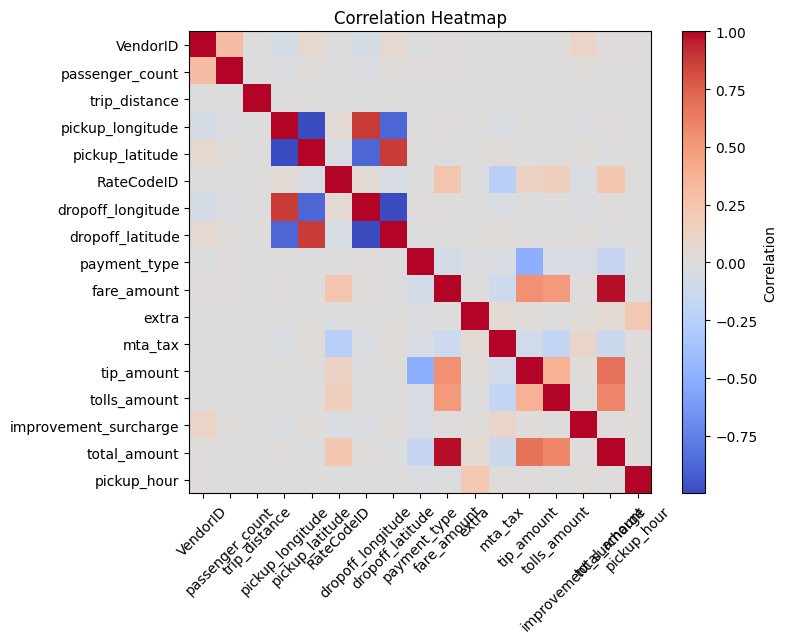

In [5]:
# =====================================
# P13 – CORRELATION & COVARIANCE
# =====================================

# 1. Correlation matrix
print("\nCorrelation Matrix:")
print(df_sample.corr(numeric_only=True))

# 2. Covariance matrix
print("\nCovariance Matrix:")
print(df_sample.cov(numeric_only=True))

# 3. Heatmap visualization of correlation matrix
plt.figure(figsize=(8,6))
plt.imshow(df_sample.corr(numeric_only=True), cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(df_sample.select_dtypes("number").columns)), df_sample.select_dtypes("number").columns, rotation=45)
plt.yticks(range(len(df_sample.select_dtypes("number").columns)), df_sample.select_dtypes("number").columns)
plt.title("Correlation Heatmap")
plt.show()


Unique pickup dates: 122
Unique pickup hours: [20 19  0 13 14 12 10  9 22 23 16 21  1  5 17  8  2  6 11 18  7 15  3  4]

Daily average fares (first 10 days):
tpep_pickup_datetime
2015-01-01    12.837768
2015-01-02    12.089675
2015-01-03    11.608781
2015-01-04    12.728381
2015-01-05    12.230989
2015-01-06    11.822433
2015-01-07    11.539284
2015-01-08    11.703352
2015-01-09    11.994189
2015-01-10    11.398400
Freq: D, Name: fare_amount, dtype: float64


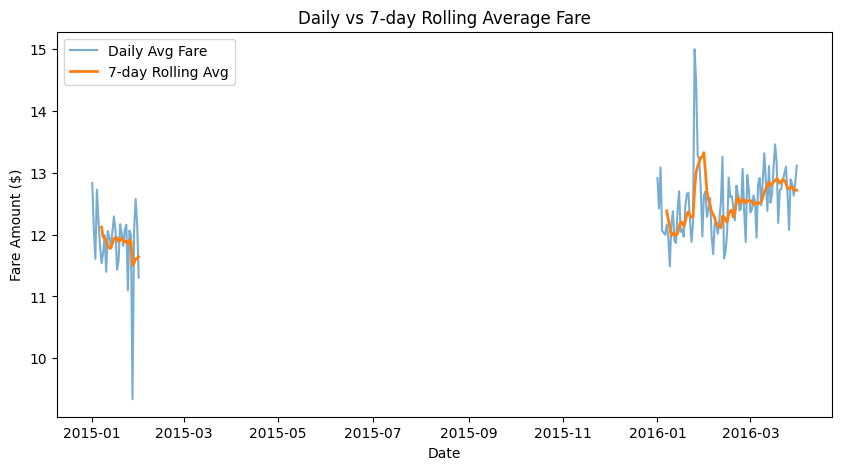

In [4]:
# =====================================
# P14 – TIME-SERIES HANDLING
# =====================================
import matplotlib.pyplot as plt
import pandas as pd

# 1. Convert to datetime
df_sample["tpep_pickup_datetime"] = pd.to_datetime(df_sample["tpep_pickup_datetime"])
df_sample["tpep_dropoff_datetime"] = pd.to_datetime(df_sample["tpep_dropoff_datetime"])

# 2. Extract date parts
df_sample["pickup_date"] = df_sample["tpep_pickup_datetime"].dt.date
df_sample["pickup_hour"] = df_sample["tpep_pickup_datetime"].dt.hour

print("\nUnique pickup dates:", df_sample["pickup_date"].nunique())
print("Unique pickup hours:", df_sample["pickup_hour"].unique())

# 3. Resample daily average fare
daily_avg = (
    df_sample.set_index("tpep_pickup_datetime")
    .resample("D")["fare_amount"]
    .mean()
)
print("\nDaily average fares (first 10 days):")
print(daily_avg.head(10))

# 4. Rolling mean of fares (7-day window)
rolling_fares = daily_avg.rolling(window=7).mean()
plt.figure(figsize=(10,5))
plt.plot(daily_avg.index, daily_avg.values, label="Daily Avg Fare", alpha=0.6)
plt.plot(rolling_fares.index, rolling_fares.values, label="7-day Rolling Avg", linewidth=2)
plt.title("Daily vs 7-day Rolling Average Fare")
plt.xlabel("Date")
plt.ylabel("Fare Amount ($)")
plt.legend()
plt.show()

In [6]:
# =====================================
# P15 – ADVANCED TOPICS
# =====================================

# 1. Concatenate multiple samples (simulate combining multiple monthly files)
chunk1 = pd.read_csv(combined_file, nrows=100000)
chunk2 = pd.read_csv(combined_file, skiprows=100000, nrows=100000, header=0)
df_concat = pd.concat([chunk1, chunk2])
print("\nConcatenated DataFrame shape:", df_concat.shape)

# 2. Merge example: join a small lookup table for payment type codes
payment_lookup = pd.DataFrame({
    "payment_type": [1,2,3,4,5,6],
    "payment_label": ["Credit Card","Cash","No Charge","Dispute","Unknown","Voided Trip"]
})
df_merged = pd.merge(df_sample, payment_lookup, on="payment_type", how="left")
print("\nMerge with payment type labels (first 5 rows):")
print(df_merged[["payment_type","payment_label"]].head())

# 3. Pivot table: average fare_amount by passenger_count and VendorID
pivot = pd.pivot_table(
    df_sample,
    values="fare_amount",
    index="passenger_count",
    columns="VendorID",
    aggfunc="mean"
)
print("\nPivot table: average fare_amount by passenger_count & VendorID")
print(pivot)

# 4. GroupBy with custom function (90th percentile tip_amount by passenger_count)
def q90(x):
    return x.quantile(0.9)

tip_stats = df_sample.groupby("passenger_count")["tip_amount"].agg(
    mean="mean", median="median", q90=q90
)
print("\nTip statistics per passenger_count:")
print(tip_stats)


Concatenated DataFrame shape: (200000, 38)

Merge with payment type labels (first 5 rows):
   payment_type payment_label
0             2          Cash
1             1   Credit Card
2             1   Credit Card
3             1   Credit Card
4             1   Credit Card

Pivot table: average fare_amount by passenger_count & VendorID
VendorID                 1          2
passenger_count                      
0                10.636163  24.387465
1                11.945196  12.548954
2                13.514931  12.496434
3                13.279319  12.254442
4                13.769374  12.111618
5                15.606449  12.423086
6                17.308460  12.270622
7                      NaN  39.857000
8                      NaN  56.833333
9                17.000000  65.766667

Tip statistics per passenger_count:
                     mean  median    q90
passenger_count                         
0                1.595300    1.00  3.200
1                1.719735    1.25  3.950
2      

# Dask

In [15]:
# =====================================
# DASK SETUP
# =====================================
import dask.dataframe as dd

# Setup dask folder
dask_folder = os.path.join(data_folder, "dask")
os.makedirs(dask_folder, exist_ok=True)
print("✔ Dask folder ready at:", dask_folder)

# Load taxi.csv into Dask DataFrame
ddf = dd.read_csv(combined_file, assume_missing=True)

print("✔ taxi.csv loaded into Dask DataFrame")
print("Dask DataFrame:", ddf)


✔ Dask folder ready at: /content/drive/MyDrive/taxi/dask
✔ taxi.csv loaded into Dask DataFrame
Dask DataFrame: Dask DataFrame Structure:
                VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance pickup_longitude pickup_latitude RateCodeID store_and_fwd_flag dropoff_longitude dropoff_latitude payment_type fare_amount    extra  mta_tax tip_amount tolls_amount improvement_surcharge total_amount
npartitions=116                                                                                                                                                                                                                                                                                          
                 float64               string                string         float64       float64          float64         float64    float64             string           float64          float64      float64     float64  float64  float64    float64      float64     

In [5]:
# =====================================
# d2: BASIC INSPECTION
# =====================================

# 1. Preview first 5 rows
print("\nFirst 5 rows:")
print(ddf.head())

# 2. List of columns
print("\nAvailable columns:")
print(ddf.columns.tolist())

# 3. Data types
print("\nData types:")
print(ddf.dtypes)

# 4. Number of rows and columns
# Dask doesn't have .shape directly -> we compute
row_count = ddf.shape[0].compute()
col_count = ddf.shape[1]
print(f"\nDataset shape: {row_count:,} rows × {col_count} columns")

# 5. Memory usage estimate (using sample)
sample = ddf.head(100000)
memory_bytes = sample.memory_usage(deep=True).sum()
memory_mb = memory_bytes / (1024 * 1024)
memory_gb = memory_bytes / (1024 * 1024 * 1024)

print("\nApproximate memory usage (per 100,000 rows):")
if memory_gb >= 1:
    print(f"{memory_gb:.2f} GB")
else:
    print(f"{memory_mb:.2f} MB")


First 5 rows:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0  2015-01-15 19:05:39   2015-01-15 19:23:42              1.0   
1       1.0  2015-01-10 20:33:38   2015-01-10 20:53:28              1.0   
2       1.0  2015-01-10 20:33:38   2015-01-10 20:43:41              1.0   
3       1.0  2015-01-10 20:33:39   2015-01-10 20:35:31              1.0   
4       1.0  2015-01-10 20:33:39   2015-01-10 20:52:58              1.0   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111         1.0   
1           3.30        -74.001648        40.724243         1.0   
2           1.80        -73.963341        40.802788         1.0   
3           0.50        -74.009087        40.713818         1.0   
4           3.00        -73.971176        40.762428         1.0   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.75061

In [16]:
# =====================================
# d3: DESCRIPTIVE STATISTICS
# =====================================
# runs for 15 mins, works but do not run

# 1. Summary statistics
print("\nSummary statistics:")
print(ddf.describe().compute())

# 2. Missing values per column
print("\nMissing values per column:")
print(ddf.isnull().sum().compute())

# 3. Value counts for categorical columns
print("\nVendorID value counts:")
print(ddf["VendorID"].value_counts().compute())

print("\nPayment type value counts:")
print(ddf["payment_type"].value_counts().compute())



Summary statistics:
           VendorID  passenger_count  trip_distance  pickup_longitude  \
count  4.724884e+07     4.724884e+07   4.724884e+07      4.724884e+07   
mean   1.529570e+00     1.667040e+00   7.508418e+00     -7.276452e+01   
std    4.991248e-01     1.322092e+00   6.487658e+03      9.381830e+00   
min    1.000000e+00     0.000000e+00  -3.390584e+06     -1.616987e+02   
25%    1.000000e+00     1.000000e+00   1.100000e+00     -7.399061e+01   
50%    2.000000e+00     1.000000e+00   1.930000e+00     -7.397933e+01   
75%    2.000000e+00     2.000000e+00   3.800000e+00     -7.396193e+01   
max    2.000000e+00     9.000000e+00   1.907263e+07      9.464387e+01   

       pickup_latitude    RateCodeID  dropoff_longitude  dropoff_latitude  \
count     4.724884e+07  4.724884e+07       4.724884e+07      4.724884e+07   
mean      4.008470e+01  1.038543e+00      -7.282501e+01      4.011889e+01   
std       5.168528e+00  5.902423e-01       9.150215e+00      5.040345e+00   
min      -7.7

In [7]:
# =====================================
# d4: PARTITIONS & PARALLELISM
# =====================================

# 1. Number of partitions
print("Current number of partitions:", ddf.npartitions) #116 partition for 40 million rows

# 2. Repartition to 100 partitions
ddf_repart = ddf.repartition(npartitions=100)
print("Repartitioned to:", ddf_repart.npartitions)

# 3. Compute rows per partition (first few only)
rows_per_part = ddf.map_partitions(len).compute()
print("\nRows per partition (first 10 partitions):", rows_per_part[:10])

Current number of partitions: 116
Repartitioned to: 100

Rows per partition (first 10 partitions): 0    408530
0    408554
0    408536
0    408555
0    408531
0    408458
0    408538
0    408527
0    408561
0    408631
dtype: int64


In [17]:
# =====================================
# d5: DASK ARRAY
# =====================================
#Run for 9 min
import dask.array as da

# Convert fare_amount column to dask array
fare_array = ddf["fare_amount"].to_dask_array(lengths=True)
#Response
#Shape: ~47.2 million values (taxi.csv has ~47M rows).
#dtype=float64: fares stored as floats.
#chunksize=(410087,): each partition holds about ~410k rows.
#chunktype=numpy.ndarray: internally it uses NumPy arrays.

print("\nFare Amount Array:", fare_array)
print("Mean:", fare_array.mean().compute()) #average cost
print("Std Dev:", fare_array.std().compute())

# Element-wise transformation
#sqrt_fares = da.sqrt(fare_array)
sqrt_fares = da.sqrt(fare_array.clip(min=0))
print("\nFirst 5 square roots of fares:", sqrt_fares[:5].compute())



Fare Amount Array: dask.array<read-getitem-_to_string_dtype-values, shape=(47248845,), dtype=float64, chunksize=(410087,), chunktype=numpy.ndarray>
Mean: 12.392189114675713
Std Dev: 78.61769957288594

First 5 square roots of fares: [3.46410162 3.80788655 3.082207   1.87082869 3.87298335]


In [18]:
# =====================================
# d7: DASK DELAYED
# =====================================
from dask import delayed

# Simple functions
def double(x): return x * 2
def cube(x): return x ** 3
def add(x, y): return x + y

# Wrap with delayed
a = delayed(cube)(2)
b = delayed(double)(2)
result = delayed(add)(a, b)

print("Result (delayed object):", result)
# Visualize the Dask task graph
result.visualize(filename="dask_delayed_graph", format="png")

# Display the generated image
from IPython.display import Image
Image("dask_delayed_graph.png")

print("Result computed:", result.compute())

Result (delayed object): Delayed('add-e62779de-c78a-46e5-b0f9-7e3203c274d3')
Result computed: 12


In [11]:
# =====================================
# d8: THREADS vs PROCESSES
# =====================================
import dask

mean_threads = ddf["fare_amount"].mean().compute(scheduler="threads")
mean_processes = ddf["fare_amount"].mean().compute(scheduler="processes")

print("Mean (threads):", mean_threads)
print("Mean (processes):", mean_processes)

#how Dask executes tasks in parallel:
#scheduler="threads"
# Uses multiple threads in the same Python process.
# Good for I/O-bound tasks (like reading CSVs, waiting on network).
# Limited by Python’s GIL (Global Interpreter Lock), so not always faster for pure Python loops.

#scheduler="processes"
# Uses multiple separate processes.
# Good for CPU-bound tasks (like heavy number crunching, simulations).
# Bypasses the GIL.

#Performance difference → If you measured runtime on bigger computations:
#For I/O-heavy operations (reading millions of rows, text parsing), threads is often faster.
#For CPU-heavy math (matrix multiplications, complex simulations), processes is often faster.


Mean (threads): 12.392189114675709
Mean (processes): 12.392189114675709


In [13]:
# =====================================
# d9: FILE FORMATS
# =====================================

# 1. Save to Parquet
parquet_path = os.path.join(dask_folder, "taxi_parquet")
ddf.to_parquet(parquet_path, engine="pyarrow", overwrite=True)
print("Saved to Parquet:", parquet_path)

# 2. Read from Parquet
ddf_parquet = dd.read_parquet(parquet_path)
print("Read back from Parquet:", ddf_parquet.head())

Saved to Parquet: /content/drive/MyDrive/taxi/dask/taxi_parquet
Read back from Parquet:    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0  2015-01-15 19:05:39   2015-01-15 19:23:42              1.0   
1       1.0  2015-01-10 20:33:38   2015-01-10 20:53:28              1.0   
2       1.0  2015-01-10 20:33:38   2015-01-10 20:43:41              1.0   
3       1.0  2015-01-10 20:33:39   2015-01-10 20:35:31              1.0   
4       1.0  2015-01-10 20:33:39   2015-01-10 20:52:58              1.0   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111         1.0   
1           3.30        -74.001648        40.724243         1.0   
2           1.80        -73.963341        40.802788         1.0   
3           0.50        -74.009087        40.713818         1.0   
4           3.00        -73.971176        40.762428         1.0   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude 

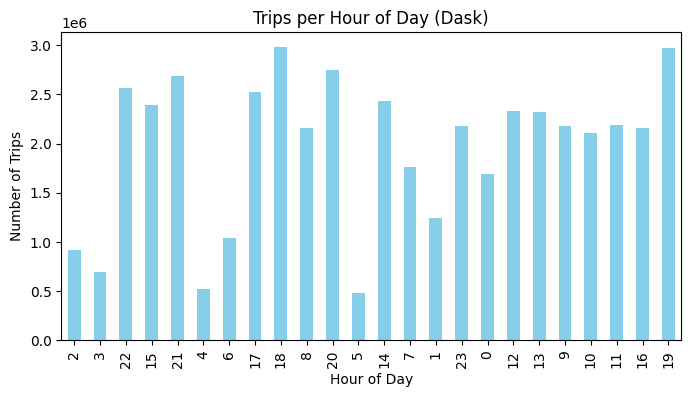

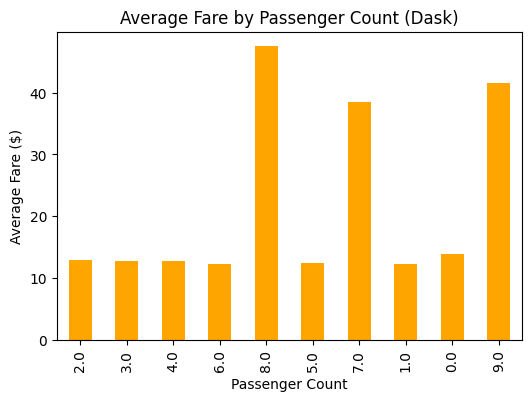

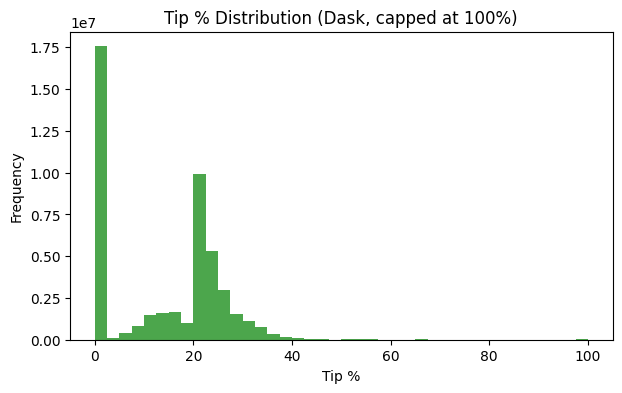

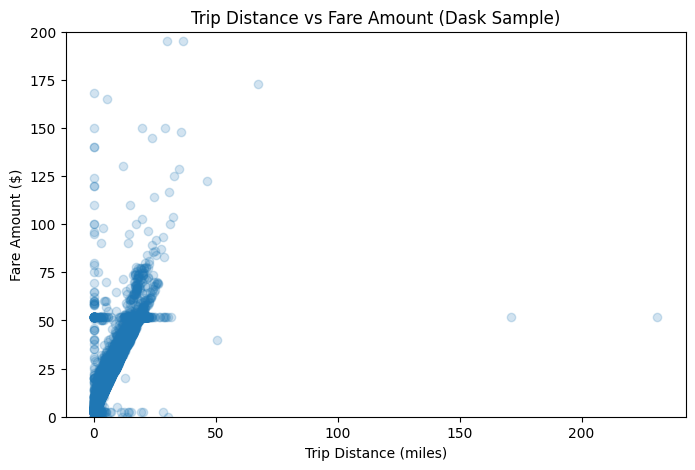

ValueError: 'columns' must be category dtype

In [20]:
# =====================================
# d10: DASK VISUALIZATIONS
# =====================================
import matplotlib.pyplot as plt

# Ensure datetime is parsed
ddf["tpep_pickup_datetime"] = dd.to_datetime(ddf["tpep_pickup_datetime"], errors="coerce")

# Extract hour and day
ddf["pickup_hour"] = ddf["tpep_pickup_datetime"].dt.hour
ddf["pickup_day"] = ddf["tpep_pickup_datetime"].dt.day_name()

# 1. Trips per hour of day
trips_per_hour = ddf.groupby("pickup_hour")["VendorID"].count().compute()
plt.figure(figsize=(8,4))
trips_per_hour.plot(kind="bar", color="skyblue")
plt.title("Trips per Hour of Day (Dask)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

# 2. Average fare by passenger count
avg_fare_passenger = ddf.groupby("passenger_count")["fare_amount"].mean().compute()
plt.figure(figsize=(6,4))
avg_fare_passenger.plot(kind="bar", color="orange")
plt.title("Average Fare by Passenger Count (Dask)")
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare ($)")
plt.show()

# 3. Tip % distribution
ddf["tip_percent"] = (ddf["tip_amount"] / ddf["fare_amount"] * 100).fillna(0)
tip_hist = ddf["tip_percent"].clip(0,100).compute()
plt.figure(figsize=(7,4))
plt.hist(tip_hist, bins=40, color="green", alpha=0.7)
plt.title("Tip % Distribution (Dask, capped at 100%)")
plt.xlabel("Tip %")
plt.ylabel("Frequency")
plt.show()

# 4. Trip distance vs Fare (scatter from sample)
sample_df = ddf.sample(frac=0.001).compute()  # 0.1% sample
plt.figure(figsize=(8,5))
plt.scatter(sample_df["trip_distance"], sample_df["fare_amount"], alpha=0.2)
plt.title("Trip Distance vs Fare Amount (Dask Sample)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.ylim(0,200)
plt.show()


# ML